In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -a 'Marcos Santana' -d -p numpy,pandas,rdkit,fastai,torch -v

Author: Marcos Santana

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy : 1.20.1
pandas: 1.2.4
rdkit : 2021.03.5
fastai: 2.5.2
torch : 1.9.0



In [2]:
import pandas as pd
import numpy as np
from fastai.text.all import *

# Load data

In [3]:
data = pd.read_csv('../data/LSTM_pretraining_data.txt',header=None,names=['Smiles']).sample(n=10000)

In [4]:
data.head()

,Smiles
498352,Cc1cccc(NC(NC(=O)c2ccco2)C(=O)c2ccccc2)c1
122736,O=C(CCc1ccc(O)cc1)NCc1ccc2ccccc2n1
484764,Cc1ccc(N2C(=O)c3ccc(C(=O)O)cc3C2=O)c(C)c1
300615,CCOc1ccccc1N(CC(=O)NCc1ccccc1)C(=O)CCC(=O)Nc1nccs1
218818,C=CCn1nc(C)c(CN2CC(CCC)C(C(=O)O)C2)c1C


# Tokenizer

We'll use a custom tokenizer to split each SMILES into individual characters. Two-letter elements (e.g. Cl and Br) and special enviroments (e.g. [C@@]) will remain as a single tokens.

In [5]:
import re

class MolTokenizer_V2():

  def tokenize_mols(self, t):
    BOS = 'xxbos'
    pat = '(\[.*?\])' # Find special enviroments (e.g., [CH],[NH] etc)
    tokens = []
    t = t.replace('Br','L').replace('Cl','X') # Replace halogens
    atom_list = re.split(pat,t)
    for s in atom_list:
      if s.startswith('['):
        tokens.append(s)
      else:
        tokens += [x for x in list(s)]
    tokens = [x.replace('L','Br').replace('X','Cl') for x in tokens] # Decode halogens
    return [BOS] + tokens

  def __call__(self, items): return (self.tokenize_mols(t) for t in items)

**Testing the tokenizer**

In [23]:
tok = Tokenizer(tok=MolTokenizer_V2(),rules=[]) # Fastai has a very handy Tokenizer wrapper. 

In [24]:
tokens = L(data.Smiles.tolist()[0:10]).map(tok)

In [25]:
' '.join(tokens[0])

'xxbos C C ( C ( = O ) N c 1 c c c ( C C N 2 C C O C 2 = O ) c c 1 ) c 1 c c c s 1'

# Text dataloader

In [26]:
splitter = RandomSplitter(0.10)
spec_toks = [BOS, PAD]
text_col = 'Smiles'
tfms = [attrgetter(text_col),
        Tokenizer.from_df(text_cols=text_col,tok=MolTokenizer_V2(),rules=[],tok_text_col=text_col),
        Numericalize(min_freq = 1, special_toks=spec_toks)]
dst = Datasets(data, tfms=[tfms], splits = splitter(data), dl_type=LMDataLoader)

/home/marcossantana/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [27]:
dls = dst.dataloaders(bs=64,seq_len=30)

In [28]:
dls.show_batch()

,text,text_
0,xxbos O = C ( C C 1 C C C C 1 ) O C c 1 n c 2 c c c c c 2 s 1 xxbos,O = C ( C C 1 C C C C 1 ) O C c 1 n c 2 c c c c c 2 s 1 xxbos C
1,c 1 c ( F ) c c c c 1 C ( = O ) N C ( C ) C ( = O ) O xxbos C O,1 c ( F ) c c c c 1 C ( = O ) N C ( C ) C ( = O ) O xxbos C O C
2,C 1 2 C C N ( C c 1 c n ( C ) c 3 c c c c c 1 3 ) C C 2 xxbos C,1 2 C C N ( C c 1 c n ( C ) c 3 c c c c c 1 3 ) C C 2 xxbos C C
3,C ( = O ) N C C N 2 C C C C C 2 C O ) c ( - c 2 c c c c c 2,( = O ) N C C N 2 C C C C C 2 C O ) c ( - c 2 c c c c c 2 )
4,c c c ( F ) c c 1 ) C 1 C C 1 ) N c 1 c c c ( F ) c c 1 Cl xxbos,c c ( F ) c c 1 ) C 1 C C 1 ) N c 1 c c c ( F ) c c 1 Cl xxbos C
5,O ) N c 1 c c c c c 1 O C ( = O ) C ( C # N ) = C c 1 c c c,) N c 1 c c c c c 1 O C ( = O ) C ( C # N ) = C c 1 c c c 2
6,C C ( = O ) N c 1 s c 2 c ( c 1 C ( = O ) O C C ( = O ) c 1,C ( = O ) N c 1 s c 2 c ( c 1 C ( = O ) O C C ( = O ) c 1 [nH]
7,) C N ( C ) C ( = O ) c 2 c c 3 c c c c c 3 [nH] 2 ) c 1 xxbos C c,C N ( C ) C ( = O ) c 2 c c 3 c c c c c 3 [nH] 2 ) c 1 xxbos C c 1
8,c c c c ( - c 2 c n c ( - c 3 c c n c c 3 ) n c 2 C 2 C C N,c c c ( - c 2 c n c ( - c 3 c c n c c 3 ) n c 2 C 2 C C N (


# Train generative model

We'll not use a pretrained model in this notebook. Let's just train from scratch. 

The default architeture in fastai is the AWD_LSTM, which is a quite robust and regularized architeture for NLP. You can check the details in the original [paper](https://arxiv.org/abs/1708.02182).

In [29]:
metrics = [accuracy]

In [30]:
learn = language_model_learner(dls, AWD_LSTM,pretrained=False,metrics=metrics,
                               drop_mult=0.75)#.load_pretrained(pretrained_path,vocab_path)
learn.unfreeze()

**Learning rate finder**

SuggestedLRs(valley=0.0003521005273796618)

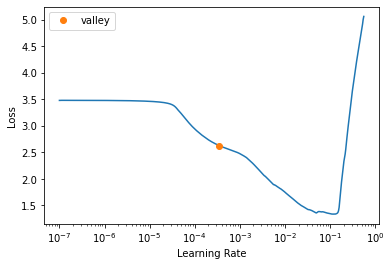

In [31]:
learn.lr_find(num_it=600)

**Training using optimal learning rate**

In [34]:
learn.fit_one_cycle(n_epoch=20,lr_max=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.749619,1.444476,0.526141,00:51
1,1.141663,0.998605,0.664848,00:52
2,0.915900,0.843609,0.703997,00:52
3,0.807525,0.773743,0.728835,00:53
4,0.773417,0.738951,0.735749,00:53
5,0.725979,0.705553,0.750752,00:53
6,0.693990,0.703743,0.752706,00:52
7,0.658255,0.679785,0.756202,00:52
8,0.650214,0.674251,0.761680,00:51
9,0.633850,0.660845,0.764958,00:55


In [35]:
learn.save('generative')

Path('models/generative.pth')

In [36]:
learn.export()

# Generate molecules

In order to generate molecules using fastai, we need to change the `predict` method a little bit. We'll include a stop criterion in order to generate many SMILES. Given a start token, the model will sample tokens until `max_size` is reached or the `stop_token` is sampled. 

In [16]:
from rdkit import Chem
from rdkit.Chem import Draw

In [8]:
class MolSampler():
    '''Basic class for molecule generation 
    
    Attributes:
    
    model_fname : str
        File name of a trained model
        
    start_token : str
        The start token of the sequence
        
    cpu : bool
        If True, predictions will happen on CPU, and GPU otherwise. 
    
    '''
    def __init__(self,model_fname:str,
                 start_token:str='',
                 cpu:bool=False):
        
        self.model = load_learner(model_fname, cpu=cpu)
        self.start_token = start_token

    def base_sampler(self, max_size, temperature, **kwargs):
        '''Base sampler to generate one SMILES using a chemistry model trained with fastai
        
        
        Attributes:
        temperature : float
        
        
            Sampling temperature to scale predictions
             
        max_size : int
        
            Maximum size of the SMILES strings
                      
            '''
        
        act = getattr(self.model.loss_func, 'activation', noop)
        self.model.model.cuda()
        self.model.model.reset()    # Reset the model
        stop_index = self.model.dls.train.vocab.index(BOS)        # Define the stop token
        idxs = self.model.dls.test_dl([self.start_token]).items[0].to(self.model.dls.device)
        nums = self.model.dls.train_ds.numericalize     # Numericalize (used to decode)
        accum_idxs = []                   # Store predicted tokens
        self.model.model.eval()

        for _ in range(max_size):
            with torch.no_grad(): preds = self.model.model(idxs[None])[0][-1]

            res = act(preds)
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            if idx != stop_index:
                accum_idxs.append(idx)
                idxs = TensorText(idxs.new_tensor([idx]))
            else:
                break
        decoded = ''.join([nums.vocab[o] for o in accum_idxs if nums.vocab[o] not in [BOS, PAD]])  # Decode predicted tokens
        return decoded

    def generate_mols(self, max_size, max_mols, temperature,**kwargs):
        '''Generate molecules using a base sampler'''

        return [self.base_sampler(max_size=max_size, temperature=temperature) for i in range(max_mols)]

In [13]:
molsampler = MolSampler(model_fname='/home/marcossantana/models/export.pkl', start_token='')

We'll use `filter` to select only valid molecules from the generated set. The `Chem.MolFromSmiles` function from rdkit will be quite useful for that. 

In [14]:
generated_mols = list(filter(Chem.MolFromSmiles, molsampler.generate_mols(max_size=120, max_mols=50, temperature=1.0)))

RDKit ERROR: [11:07:08] non-ring atom 9 marked aromatic
RDKit ERROR: [11:07:08] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 
RDKit ERROR: [11:07:08] SMILES Parse Error: extra open parentheses for input: 'CC(C)CCC(NC(=O)C(C)(C)C)c1ccc(OCc2c(c1)OCO2'
RDKit ERROR: [11:07:08] SMILES Parse Error: extra open parentheses for input: 'CCC(Cc1noc(NCc2ccc(F)cc2)n1N'
RDKit ERROR: [11:07:08] Can't kekulize mol.  Unkekulized atoms: 12 14
RDKit ERROR: 
RDKit ERROR: [11:07:08] SMILES Parse Error: extra close parentheses while parsing: CCOc1ccc(C2CC(c3ccc4c(c3)OCO4)N3CCCC3)C2=O)cc1
RDKit ERROR: [11:07:08] SMILES Parse Error: Failed parsing SMILES 'CCOc1ccc(C2CC(c3ccc4c(c3)OCO4)N3CCCC3)C2=O)cc1' for input: 'CCOc1ccc(C2CC(c3ccc4c(c3)OCO4)N3CCCC3)C2=O)cc1'
RDKit ERROR: [11:07:08] SMILES Parse Error: extra open parentheses for input: 'COCCN1C(=O)C(=C2C(=O)N(c3ccc(C)c(C)c3)C(=O)C2C1=O'
RDKit ERROR: [11:07:08] SMILES Parse Error: extra open parentheses for input: 'Cc1cccc(COc2cccc(C(=O)N3CC4CCC(C2

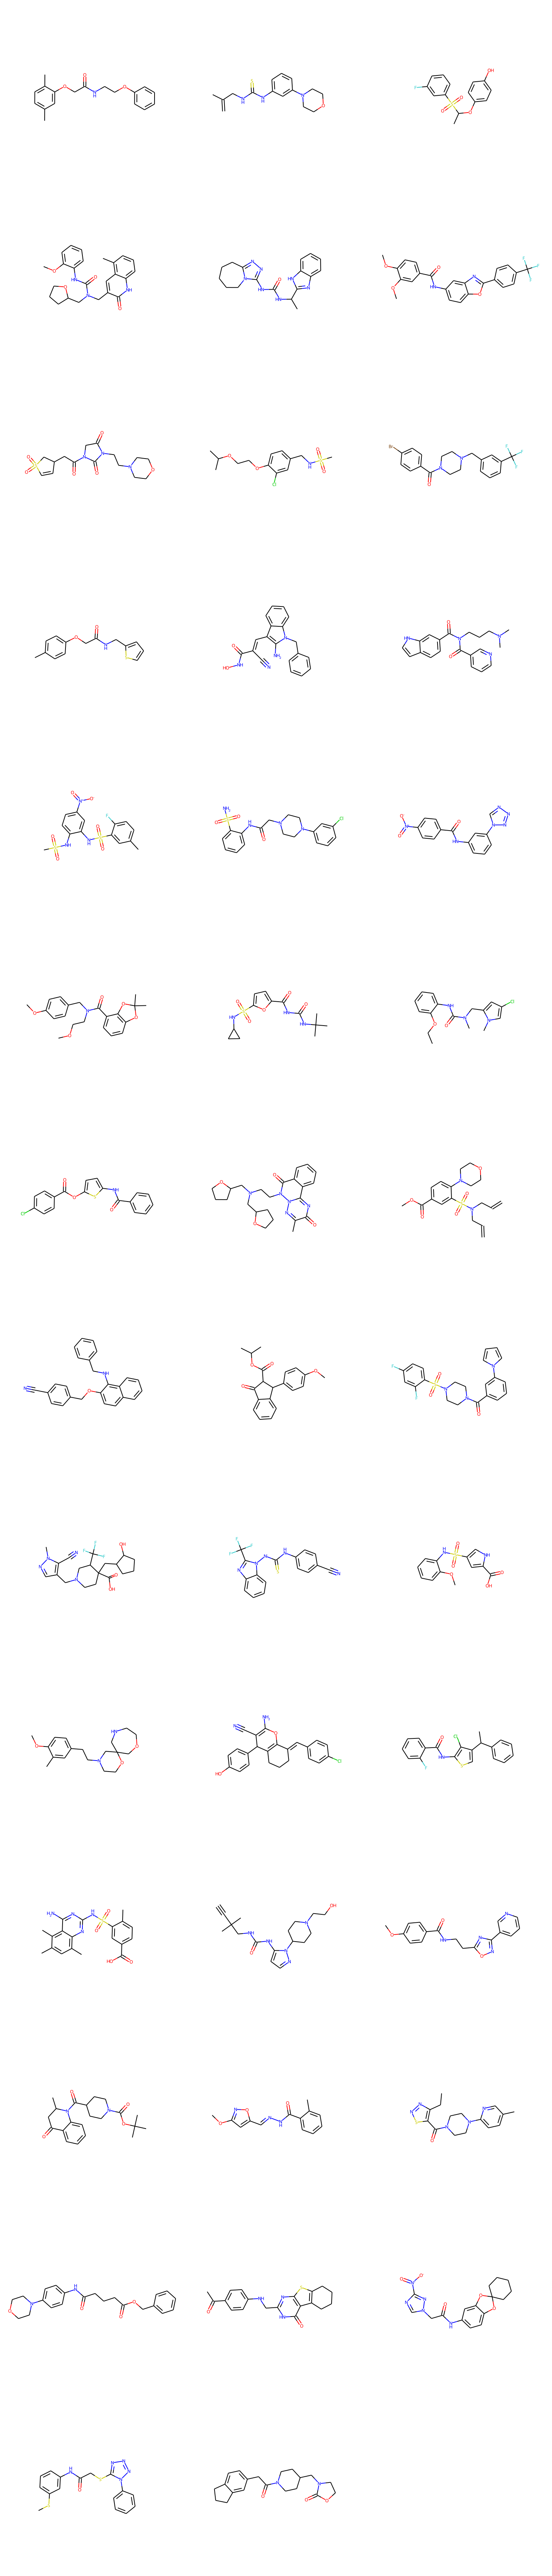

In [18]:
Draw.MolsToGridImage(list(map(Chem.MolFromSmiles, generated_mols)),maxMols=50,subImgSize=(500,500))

# Fin